<a href="https://colab.research.google.com/github/jjone36/Groot/blob/master/96_cnn_Doodle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Catch Doodle!: Quick draw

In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(style='white', context='notebook')

In [0]:
import ast

from keras.models import Sequentials
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization

## Load data

In [4]:
# Connecting to kaggle API
from google.colab import files
file = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
from getpass import getpass
user = 'jjone36'
key = 'cf8dcde20a60798fe4fb91b2ba5158e8'

if '.kaggle' not in os.listdir('/root'):
    !mkdir ~/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 666 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (user, key))
!chmod 600 /root/.kaggle/kaggle.json

In [8]:
!kaggle competitions download -c quickdraw-doodle-recognition

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test_raw.csv: Skipping, found more recently modified local copy (use --force to force download)
test_simplified.csv: Skipping, found more recently modified local copy (use --force to force download)
train_raw.zip: Skipping, found more recently modified local copy (use --force to force download)
100% 7.36G/7.37G [02:27<00:00, 75.7MB/s]
100% 7.37G/7.37G [02:28<00:00, 53.5MB/s]


In [0]:
# Unzip the file
from zipfile import ZipFile
zf = ZipFile('train_simplified.zip', 'r')

In [0]:
# list of animals 
animals = ['ant', 'bat', 'bear', 'bee', 'bird', 'butterfly', 'camel', 'cat', 'cow',
           'crab', 'crocodile', 'dog', 'dolphin', 'dragon', 'duck', 'elephant', 'fish',
           'flamingo', 'frog', 'giraffe', 'hedgehog', 'horse', 'kangaroo', 'lion',
           'lobster', 'monkey', 'mosquito', 'mouse', 'octopus', 'owl', 'panda',
           'parrot', 'penguin', 'pig', 'rabbit', 'raccoon', 'rhinoceros', 'scorpion',
           'sea turtle', 'shark', 'sheep', 'snail', 'snake', 'spider', 'squirrel',
           'swan', 'teddy-bear', 'tiger', 'whale', 'zebra']

In [0]:
# Import data: animals only
for a in animals:
  file = a + str('.csv')
  zf.extract(file, path= '/content/animals')

In [12]:
dir_path = '/content/animals/'

am = pd.read_csv(dir_path + animals[0] + '.csv')
am.head()

,countrycode,drawing,key_id,recognized,timestamp,word
0,US,"[[[27, 17, 16, 21, 34, 50, 49, 34, 23, 17], [4...",5421013154136064,True,2017-03-27 00:14:57.310330,ant
1,US,"[[[27, 0, 7, 40, 47, 20], [0, 41, 74, 73, 41, ...",4836123148812288,True,2017-03-06 20:00:22.521560,ant
2,US,"[[[34, 18, 14, 4, 1, 2, 10, 18, 46, 69, 83, 89...",5720952853757952,True,2017-01-23 19:53:28.354530,ant
3,US,"[[[59, 33, 16, 10, 61, 71, 69], [33, 36, 46, 5...",6345979559149568,True,2017-03-14 14:52:27.521410,ant
4,US,"[[[17, 16, 19], [140, 167, 177]], [[81, 82, 87...",4704383923126272,True,2017-01-25 21:48:31.256400,ant


In [0]:
# Take only recognizable drawings
am = am[am.recognized == True]

In [0]:
# Attach other files into one dataframe
for a in animals[1:]:
    df = pd.read_csv(dir_path + a + '.csv')
    df = df[df.recognized == True]
    am = am.append(df)

In [15]:
# Checking
am.word.nunique()

50

In [0]:
am = am.sample(frac = 1).reset_index(drop = True)

## Data Distribution check

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


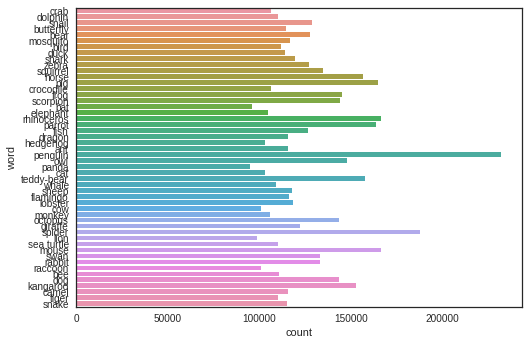

In [17]:
# Distributions of animals
sns.countplot(y = 'word', data = am)

In [0]:
# Resampling 
n = 100000
am_2 = pd.DataFrame(columns= am.columns)

for a in animals:
  df = am[am['word'] == a]
  if len(df) > n:
    df = df.sample(n)
    am_2 = am_2.append(df)
  else:
    am_2 = am_2.append(df)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


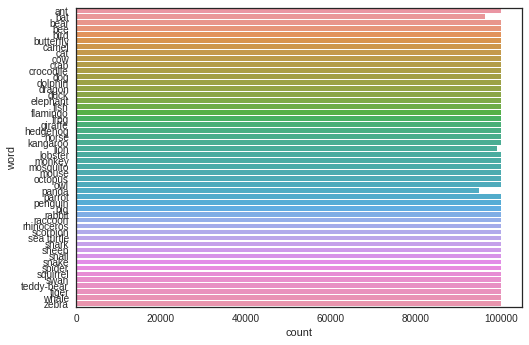

In [39]:
# Checking again
sns.countplot(y = 'word', data = am_2)

In [0]:
# Reindexing
am_2 = am_2.sample(frac = 1).reset_index(drop = True)

## Let's draw doodle!

In [45]:
am_2.head()

,countrycode,drawing,key_id,recognized,timestamp,word
0,BR,"[[[65, 94, 108, 121, 147, 180, 203, 222, 231, ...",6656832032473088,True,2017-01-25 20:51:19.452420,dragon
1,IT,"[[[195, 201, 207, 221, 230, 250, 255, 254, 242...",5515738657849344,True,2017-03-25 23:57:16.939330,snail
2,US,"[[[108, 77, 38, 27, 0, 3, 39, 112, 87], [41, 2...",6330715614478336,True,2017-03-27 18:55:17.767670,mosquito
3,US,"[[[38, 43, 68, 95, 110, 138, 139, 126, 107, 75...",5220670713626624,True,2017-03-29 22:42:11.385440,teddy-bear
4,JO,"[[[220, 199, 186, 179, 175, 171, 145, 133, 119...",6109789593534464,True,2017-03-13 16:08:43.207720,sheep


In [0]:
am_2['drawing'] = am_2.drawing.apply(ast.literal_eval)

In [1]:
ex = am_2.sample(100)

NameError: ignored

In [0]:
fig, axs = plt.subplot(nrows = 10, ncols = 10, figsize = (10, 10))
for post, cont in enumerate(ex.drawing):
  ax = axs[post // n, post % n]
  for x, y in cont:
    ax.plot(x, y, lw = 3)
  ax.axis('off')
  
plt.show()

## Modeling

In [0]:
im_size = 32
batchsize = 512

In [0]:
# 